In [2]:
import pandas as pd
import sqlite3
from tqdm import tqdm

In [4]:
tqdm.pandas()

In [2]:
conn = sqlite3.connect("sites.db")
cur = conn.cursor()

## Подготавливаем БД для подсчёта

Почему-то этого сайта не было в sites, хотя четыре сотни его страниц в pages были. Добавлю руками, ибо сайтов у нас мало, терять ещё больше не хочется.

In [39]:
cur.execute("INSERT INTO sites (url, site_name) SELECT url, page_name FROM pages WHERE id=6727")
conn.commit()

In [7]:
cur.execute("ALTER TABLE pages ADD home_id INTEGER")
conn.commit()

In [8]:
sites = pd.read_sql_query("SELECT * FROM sites", conn)

In [11]:
sites.set_index("id", inplace=True)

In [8]:
def clean_url(url):
    result = url.split("/")[2]
    if result.startswith("www."):
        result = result.replace("www.", "", 1)
    return result

In [9]:
sites["url_clear"] = sites["url"].apply(lambda url: clean_url(url))

In [10]:
for site in tqdm(sites.itertuples(), total=sites.shape[0]):
    cur.execute(f"UPDATE pages SET home_id={site.Index} WHERE url LIKE '%{site.url_clear}%'")

100%|███████████████████████████████████████████████████████████████████████████████████| 91/91 [01:28<00:00,  1.03it/s]


In [11]:
conn.commit()

In [9]:
cur.execute("CREATE INDEX idx_page_site ON pages(home_id)")
conn.commit()

In [5]:
cur.execute("ALTER TABLE sites ADD words_mean INTEGER")
cur.execute("ALTER TABLE sites ADD words_median INTEGER")
cur.execute("ALTER TABLE sites ADD embedded_mean INTEGER")
cur.execute("ALTER TABLE sites ADD keywords TEXT")
conn.commit()

## Считаем метрики для каждого сайта

In [5]:
sites = pd.read_sql_query("SELECT * FROM sites", conn)

In [6]:
sites.set_index("id", inplace=True)

In [130]:
from natasha import Segmenter, MorphVocab, NewsEmbedding, NewsMorphTagger, Doc
from collections import Counter
from random import sample
import traceback
import re
import gc

In [8]:
def count_embedded(html):
    tags = "<audio|<canvas|<embed|<iframe|<img|<object|<picture|<video"
    return len(re.findall(tags, html))

In [9]:
segmenter = Segmenter()
morph_vocab = MorphVocab()
emb = NewsEmbedding()
morph_tagger = NewsMorphTagger(emb)

In [10]:
def get_nouns(text):
    doc = Doc(text)
    doc.segment(segmenter)
    doc.tag_morph(morph_tagger)
    nouns = []
    for token in doc.tokens:
        if token.pos == 'NOUN' and len(token.text) > 2 and token.text[0].lower() in "абвгдеёжзийклмнопрстуфхцчшщъыьэюя":
            token.lemmatize(morph_vocab)
            nouns.append(token.lemma)
    return Counter(nouns)

In [13]:
def get_site_stats(site_id):
    df = pd.read_sql_query(f"SELECT * FROM pages WHERE home_id={site_id}", conn)
    
    # считаем слова (грубо)
    df["word_count"] = df["plain_text"].apply(lambda x: len(x.split()))

    # считаем embedded content (метаобъекты?)
    df["embedded"] = df["pure_html"].apply(lambda x: count_embedded(x))

    # считаем существительные
    ids = df[df.home_id == site_id]["id"].values.tolist()
    sample_size = int(len(ids) * 0.1) if len(ids) >= 100 else min(len(ids), 10)
    selected = sample(ids, min(50, sample_size))
    df["nouns_count"] = df.apply(lambda row: get_nouns(row["plain_text"]) if row["id"] in selected else Counter(), axis=1)

    # ищем метрики и пишем в базу сайтов
    words_mean = int(df["word_count"].mean())
    words_median = int(df["word_count"].median())
    embedded_mean = int(df["embedded"].mean())
    keywords = ','.join([word[0] for word in df["nouns_count"].sum().most_common(10)])
    del df
    gc.collect()
    sites.at[site_id, "words_mean"] = words_mean
    sites.at[site_id, "words_median"] = words_median
    sites.at[site_id, "embedded_mean"] = embedded_mean
    sites.at[site_id, "keywords"] = keywords
    if not keywords:
        keywords = "-1"
    cur.execute(f"""UPDATE sites 
                    SET words_mean={words_mean}, words_median={words_median}, 
                    embedded_mean={embedded_mean}, keywords="{keywords}"
                    WHERE id={site_id}""")

In [14]:
for site_id in tqdm(sites.index):
    try:
        get_site_stats(site_id)
    except Exception:
        print(f"Failure on site {site_id}")
        traceback.print_exc()
    conn.commit()

100%|███████████████████████████████████████████████████████████████████████████████████| 91/91 [32:59<00:00, 21.75s/it]


In [195]:
sites.to_csv("sites_counted.csv")

## Рисуем

In [3]:
sites = pd.read_csv("sites_counted.csv")

In [25]:
import matplotlib.pyplot as plt
import numpy as np
from wordcloud import WordCloud, STOPWORDS
from collections import Counter

In [11]:
def count_bin(col, rng):
    rng = rng.replace('+', '-')
    rng = rng.split("-")
    low = int(rng[0])
    high = sites[col].max() if not rng[1] else int(rng[1])
    return len(sites[(sites[col] >= low) & (sites[col] < high)])

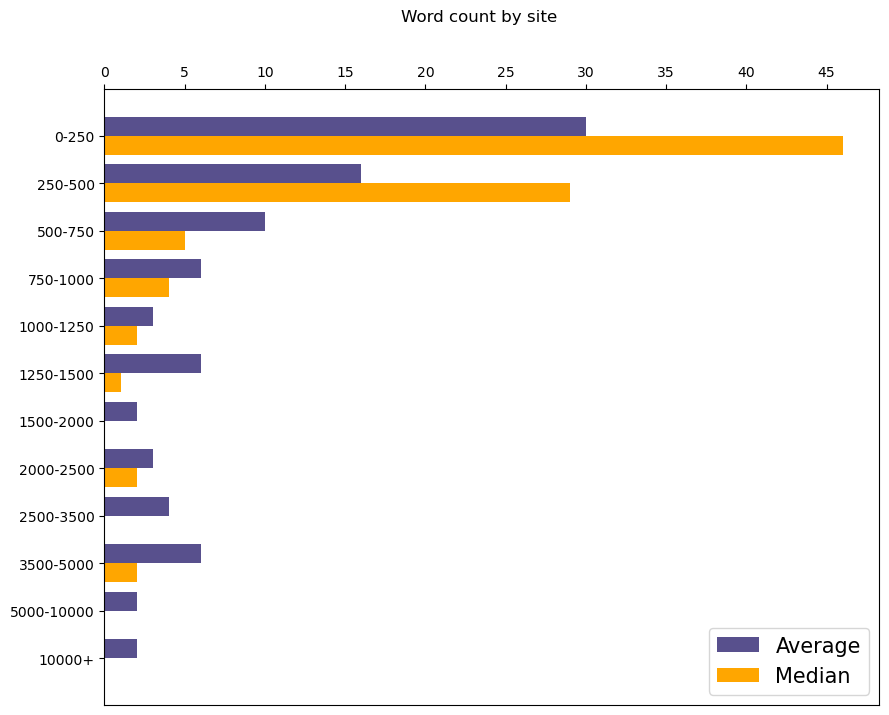

In [56]:
bins = ["0-250", "250-500", "500-750", "750-1000", "1000-1250", "1250-1500", 
              "1500-2000", "2000-2500", "2500-3500", "3500-5000", "5000-10000", "10000+"]
word_mean_count = [count_bin("words_mean", bin) for bin in bins]
word_median_count = [count_bin("words_median", bin) for bin in bins]

fig, ax = plt.subplots(figsize=(10, 8))
fig.suptitle("Word count by site")
x = np.arange(len(bins))
width = 0.2

ax.barh(x - width, word_mean_count, width * 2, color='#58508d')
ax.barh(x + width, word_median_count, width * 2, color='#ffa600')

ax.set_xticks(np.arange(min(word_mean_count + word_median_count), 
                        max(word_mean_count + word_median_count), 5))
ax.set_yticks(x, bins)
ax.xaxis.set_ticks_position('top')
ax.invert_yaxis()
ax.legend(["Average", "Median"], fontsize="15")

fig.savefig("word_count.png")

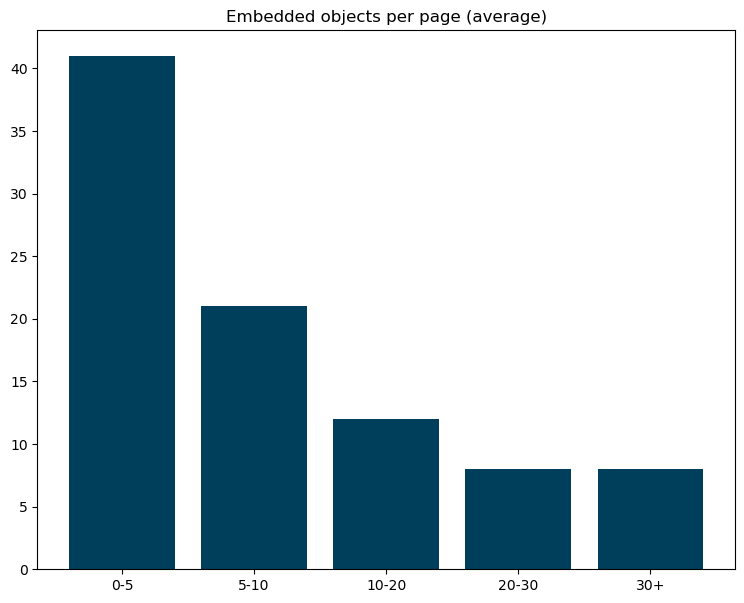

In [55]:
bins = ["0-5", "5-10", "10-20", "20-30", "30+"]
meta_count = [count_bin("embedded_mean", bin) for bin in bins]

plt.figure(figsize=(9, 7))
plt.title("Embedded objects per page (average)")
plt.bar(bins, meta_count, color="#003f5c")
plt.savefig("embed.png")

In [20]:
kw_helper = sites["keywords"] + ','

In [27]:
kw_freq = Counter(kw_helper.dropna().sum()[:-1].split(','))

In [29]:
stopwords = ["сайт", "год"]
for sword in stopwords:
    del kw_freq[sword]

In [51]:
wordcloud = WordCloud(stopwords=STOPWORDS, width=1000, height=800, 
                      relative_scaling=0.5, colormap="Spectral").generate_from_frequencies(kw_freq)

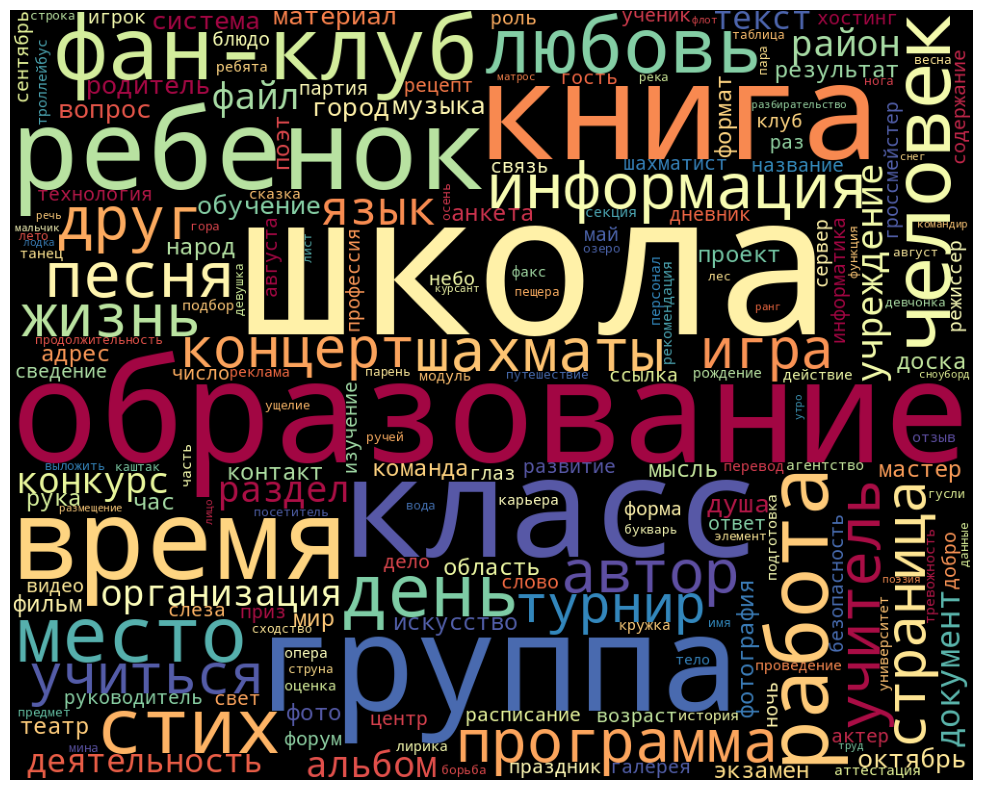

In [54]:
plt.figure(figsize=(15, 10))
plt.imshow(wordcloud)
plt.axis("off")
plt.savefig("cloud.png")

## 

In [46]:
# тестовая
# def set_keywords(site_id):
#     df = pd.read_sql_query(f"SELECT * FROM pages WHERE home_id={site_id}", conn)
#     ids = df[df.home_id == site_id]["id"].values.tolist()
#     sample_size = int(len(ids)) * 0.1 if len(ids) >= 100 else min(len(ids), 10)
#     selected = sample(ids, min(50, sample_size))
#     df["nouns_count"] = df.apply(lambda row: get_nouns(row["plain_text"]) if row["id"] in selected else Counter(), axis=1)
    
#     keywords = ','.join([word[0] for word in df["nouns_count"].sum().most_common(10)])
#     print(keywords)
#     if not keywords:
#         keywords = "-1"
#     sites.at[site_id, "keywords"] = keywords
#     cur.execute(f"""UPDATE sites 
#                     SET keywords="{keywords}"
#                     WHERE id={site_id}""")

In [19]:
# тестовое
# for site_id in sites.index:
#     if sites.loc[site_id]["keywords"] == '':
#         try:
#             get_site_stats(site_id)
#         except Exception:
#             print(f"Failure on site {site_id}")
#             traceback.print_exc()
#         conn.commit()

In [216]:
# fig, ax = plt.subplots(2, 1, sharex=True, figsize=(8, 8), tight_layout=True)
# fig.suptitle("        Word count by site")
# bins = ["0-250", "250-500", "500-750", "750-1000", "1000-1250", "1250-1500", 
#               "1500-2000", "2000-2500", "2500-3000", "3000-3500", "4000-5000", "5000-10000", "10000+"]

# ax[0].invert_yaxis()
# ax[0].title.set_text("Average")
# word_mean_counts = [count_bin("words_mean", bin) for bin in bins]
# ax[0].barh(word_mean_bins, word_mean_counts, color='#573391')

# ax[1].invert_yaxis()
# ax[1].title.set_text("Median")
# word_median_counts = [count_bin("words_median", bin) for bin in bins]
# ax[1].barh(word_median_bins, word_median_counts, color='#357c3c')